In [145]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from memory_profiler import profile 
import numpy as np

In [2]:
# This script will train a neural network to identify numbers from images taken 
# from zip codes written on envelopes from the USPS. 
# 
# Tasks: 
# 1) Import the training and test data 
# 2) Plot a few candidate data points 
# 3) Build a convolutional neural net model to train on the test data 
# 4) Inspect the training and test losses 
# 5) Observe error rate and error rate, given a particular rejection rate. 
# 6) Observe the activation and gradient statistics of the model
# 7) Sample the model. 

In [48]:
Xtr, Xte = [], []
Ytr, Yte = [], []

with open("dataset/zip.train", 'r') as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Ytr.append(int(float(data[0])))
        Xtr.append([float(d) for d in data[1:]])
    Ytr = torch.tensor(Ytr)
    Xtr = torch.tensor(Xtr)
    Xtr = Xtr.view(Xtr.shape[0], 16, 16)
    
with open("dataset/zip.test", "r") as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Yte.append(int(float(data[0])))
        Xte.append([float(d) for d in data[1:]])
    Yte = torch.tensor(Yte)
    Xte = torch.tensor(Xte)
    Xte = Xte.view(Xte.shape[0], 16, 16)

print(f"Training Data Length = {len(data_train)}, Test Data Length = {len(data_test)}")

Training Data Length = 7291, Test Data Length = 2007


Examples from the Training Set


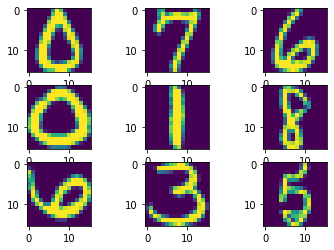

In [64]:
print("Examples from the Training Set")
fig, axs = plt.subplots(3,3)
ix = torch.randint(0, Xtr.shape[0], (9, ))
i = 0
for row in axs: 
    for col in row: 
        col.imshow(Xtr[ix[i]])
        i += 1

In [409]:
 # Create Layer, BatchNorm, Tanh classes

# ------------------------------------------------------------------------------
class Linear: 
    def __init__(self, fanin, fanout, bias=False):
        self.weight = torch.randn([fanin, fanout]) / (fanin**0.5)
        self.bias = torch.zeros(fanout) if bias else None
    
    def __repr__(self):
        return f"Linear({tuple(self.weight.shape)})"
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            return self.out + self.bias
        else: 
            return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------
class BatchNorm1d: 
    def __init__(self, dim, momentum=0.1, tol=1e-5, training=True):
        # dim is the number of examples used in the batch 
        self.momentum = momentum 
        self.training = training
        self.dim = dim 
        self.tol = tol
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) 
    
    def __repr__(self):
        return f"BatchNorm1d[({self.dim}, {self.momentum}) | {self.training}]"
    
    def __call__(self, x): 
        if self.training: 
            if x.ndim == 2: 
                dim = 0
            elif x.ndim == 3: 
                dim = (0, 1)
            xmean = x.mean(dim, keepdims=True)
            xvar = x.var(dim, keepdims=True, correction=1) # bessel's correction 
            self.out = self.gamma * (x - xmean) * (xvar + self.tol) ** (-0.5) + self.beta
            with torch.no_grad(): 
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1-self.momentum) * self.running_var
            
        else: 
            self.out = self.gamma * (x - self.running_mean) * (self.running_var + self.tol) ** (-0.5) + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# ------------------------------------------------------------------------------
class Tanh:
    def __repr__(self):
        return f"Tanh"
    
    def __call__(self, x): 
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    
# ------------------------------------------------------------------------------
class Conv2d: 
    def __init__(self, channels_in, channels_out, kernel_size, stride, padding, bias=True): 
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.kernel_size = kernel_size
        self.padding = padding
        if isinstance(self.padding, int): 
            self.padding = (padding, padding)   # symmetrical padding is required 
        self.stride = stride
        if isinstance(self.stride, int): 
            self.stride = (stride, stride)
        if isinstance(self.kernel_size, int): 
            self.kernel_size = (kernel_size, kernel_size)
        self.weight = torch.randn(channels_out, self.kernel_size[0] * self.kernel_size[1] * channels_in)
        self.bias = torch.randn(channels_out, 1, 1) if bias else None
        
    def __repr__(self):
        return f"Conv2d({self.channels_in}ch_in, {self.channels_out}ch_out, {self.kernel_size} kernel_size, {self.stride} stride, {self.padding} padding)"
    
    @property
    def bias(self):
        return self._bias
    
    @bias.setter
    def bias(self, bias): 
        assert len(bias) == self.channels_out
        self._bias = bias.view(self.channels_out, 1, 1)
    
    def __call__(self, x):
        batch_size = x.shape[0]
        out_shape_width = (x.shape[-1] + (2*self.padding[1]) - self.kernel_size[1])/(self.stride[1]) + 1
        out_shape_height = (x.shape[-2] + (2*self.padding[0]) - self.kernel_size[0])/(self.stride[0]) + 1
        
        assert out_shape_width.is_integer(), "Combination of input volume, kernel_size, padding, and stride not acceptable in width dimension"
        assert out_shape_height.is_integer(), "Combination of input volume, kernel_size, padding, and stride not acceptable in height dimension"
        
        out_shape_width = int(out_shape_width)
        out_shape_height = int(out_shape_height)
        
        input_col = self.im2col(x)
        weights_row = self.weight.view(self.channels_out, self.kernel_size[0] * self.kernel_size[1] * self.channels_in)
#         print(f"input_col output {tuple(input_col.shape)}:")
#         print(f"x={x}")
#         print(f"input_col = {input_col.T}")
#         print(f"weights_row matrix {tuple(weights_row.shape)}:")
#         print(f"self.weight = {self.weight}")
#         print(f"weights_row = {weights_row}")
        self.out = (weights_row @ input_col.T).T 
        self.out = self.out.view(batch_size, self.channels_out, out_shape_height, out_shape_width)
        self.out = self.out + self.bias if self.bias is not None else self.out
        return self.out
        
    def im2col(self, x):
        """
        Our own version of im2col to make efficient conv2d.
        Input: input tensor to unfold 
        Output: 3D tensor (N, C, L) where N is batch size, C is channels_in * self.kernel_size[0] * self.kernel_size[1], and L is how many blocks exist while sliding over a single input slice 
        """
        unfold = torch.nn.Unfold(self.kernel_size, 1, self.padding, self.stride)
        output = unfold(x)
        return output
        
    def parameters(self): 
        return [self.weight]
    
# ------------------------------------------------------------------------------
class Embedding: 
    def __init__(self, num_embedding, dim_embedding): 
        self.weight = torch.randn([num_embedding, dim_embedding])
    
    def __repr__(self):
        return f"Embedding({tuple(self.weight.shape)})"
    
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# ------------------------------------------------------------------------------
class Flatten: 
    """
    Flattens the input matrix outside of the batch dimension (first dimension)
    """
    def __call__(self, x): 
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return f"Flatten()"

# ------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x): 
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x 
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return f"FlattenConsecutive({self.n})"
    
# ------------------------------------------------------------------------------
class Sequential: 
    def __init__(self, layers): 
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # return parameters for all parameters in each layer
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"Sequential({self.layers})"
    
    def append(self, layer): 
        self.layers.append(layer)

In [389]:
batch_size = 1
channels_in = 2
channels_out = 2
input_vol = torch.tensor(np.linspace(1,16,16),  dtype=torch.float).view(1, 1, 4, 4)
input_vol = torch.zeros(1,channels_in,4,4)
input_vol[0, 0,:] = input_vol_temp
input_vol[0, 1,:] = -input_vol_temp
kernel = torch.randn(channels_out,channels_in,2,2)
bias = torch.randn(channels_out)
# kernel = torch.tensor([[1.0,2.0],[3.0,4.0]], dtype=torch.float)
# kernel = torch.tensor([[[1.0,2.0],[3.0,4.0]], [[-1.0,-2.0],[-3.0,-4.0]]], dtype=torch.float)
kernel = kernel.view(channels_out, channels_in, 2, 2)
padding = 0
stride = 1

conv2d_torch = torch.nn.Conv2d(channels_in, channels_out, kernel.shape[-2:], stride=stride, padding=padding, bias=True)
conv2d_torch.weight = torch.nn.Parameter(kernel)
conv2d_torch.bias = torch.nn.Parameter(bias)
conv2d_custom = Conv2d(channels_in, channels_out, kernel.shape[-2:], stride, padding, True)
conv2d_custom.weight = kernel
conv2d_custom.bias = bias

# print(input_vol)
# print(kernel)

output_torch = conv2d_torch(input_vol)
output_custom = conv2d_custom(input_vol)
print(output_torch)
print(output_custom)
print(torch.allclose(output_torch, output_custom))

print(output_torch.shape)
print(output_custom.shape)

tensor([[[[  2.7375,   4.5040,   6.2706],
          [  9.8036,  11.5702,  13.3367],
          [ 16.8698,  18.6363,  20.4029]],

         [[-30.0408, -36.4892, -42.9375],
          [-55.8341, -62.2824, -68.7308],
          [-81.6274, -88.0757, -94.5240]]]], grad_fn=<ConvolutionBackward0>)
tensor([[[[  2.7375,   4.5040,   6.2706],
          [  9.8036,  11.5702,  13.3367],
          [ 16.8698,  18.6363,  20.4029]],

         [[-30.0408, -36.4891, -42.9375],
          [-55.8341, -62.2824, -68.7308],
          [-81.6274, -88.0757, -94.5240]]]])
True
torch.Size([1, 2, 3, 3])
torch.Size([1, 2, 3, 3])


torch.Size([7291, 16, 16])

32.0